# Beer Analysis

For this project I scraped the ratings of 458,978 beers from a popular beer rating website. I will conduct some analysis on the beers and their ratings and try to develop a model to predict the rating of a beer based on some of its features.

In [2]:
# Python Standard Library
import json
import random

# Python 3rd-Party Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble \
    import RandomForestRegressor, GradientBoostingRegressor
from sklearn import tree

## Helper Functions

The following functions will be useful for analysis and preprocessing of the data.

In [13]:
# Some functions for analysis and preprocessing
# ------------------------------------------------------------------------------
def encode(df, column):
    """Encodes column in df (replacing w/ encoded) and returns encoder
    
    df: pd.DataFrame
    column: str
    """
    le = LabelEncoder()
    le.fit(df[column])
    df[column] = le.transform(df[column])
    return le

def getMostCommonTags(df, tagscol='tags', n=40):
    """Returns n most common tags as a list
    
    df: pd.DataFrame
    col: str
    n: int
    """
    tagcount = dict()
    for tags in df[tagscol]:
        for tag in tags:
            tagcount[tag] = tagcount.setdefault(tag, 0) + 1
    taglist = list(tagcount.items())
    taglist.sort(key=lambda x: x[1], reverse=True)
    return [tag for tag, _ in taglist[:n]]

def encodeTags(df, tagscol='tags', tags=None):
    """Inserts columns for each tag in tags so that if record has tag 
         entry is 1, else entry is 0 (a binary encoding)
    
    df: pd.DataFrame
    tagscol: str
    tags: list
    """
    tags = tags if tags is not None else []
    kwargs = dict()
    for tag in tags:
        kwargs[tag] = df[tagscol].map(lambda x: int(tag in x))
    return df.assign(**kwargs)

# ------------------------------------------------------------------------------
def split(df, split=[0.6, 0.2, 0.2]):
    """Split data into train, validation, test using percentages in split
    
    df: pd.DataFrame
    split: list
    """
    size = len(df)
    firstsplit = int(split[0]*size)
    if len(split) == 3 or sum(split) != 1:
        secondsplit = int(sum(split[0:2])*size)
        train, valid, test = \
            np.split(df.sample(frac=1), [firstsplit, secondsplit])
        return train, valid, test
    else:
        train, test = np.split(df.sample(frac=1), [firstsplit])
        return train, test


def cost(y, yhat, criteria='mse'):
    """Returns MSE or MAE
    
    y: pd.Series / np.array
    yhat: pd.Series / np.array
    """
    if criteria == 'mse':
        return (1.0/len(y))*np.sum(np.square(y-yhat))
    elif criteria == 'mae':
        return (1.0/len(y))*np.sum(np.abs(y-yhat))


def insertAvgByGroup(df, group, toavg='rating'):
    """Inserts column with average for a specified group
    
    df: pd.DataFrame
    group: str
    toavg: str
    """
    groupMeans = df.groupby(by=[group])[toavg].mean()
    kwargs = {group + 'avg': df[group].map(lambda x: groupMeans[x])}
    return df.assign(**kwargs)


def insertCntByGroup(df, group, tocnt='rating'):
    """Inserts column with counts for a specified group
    
    df: pd.DataFrame
    group: str
    tocnt: str
    """
    groupCnts = df.groupby(by=[group])[tocnt].count()
    kwargs = {group + 'cnt': df[group].map(lambda x: groupCnts[x])}
    return df.assign(**kwargs)


# ------------------------------------------------------------------------------
def getRandomRecords(count, df, column='beer'):
    """Randomly chooses and returns list of records from column of length count
    
    count: int
    df: pd.DataFrame
    column = str
    """
    randm = []
    for i in range(count):
        idx = random.choice(df.index)
        randm.append(df.loc[idx, column])
    return randm


def filterRecords(df, tofilter, filtercol='beers'):
    """Returns DataFrame with filtered records
    
    df: pd.DataFrame
    tofilter: list
    filtercol: str
    """
    copy = df.copy()
    return copy.loc[df[filtercol].map(lambda x: x in tofilter), :]

# ------------------------------------------------------------------------------

def evaluate(y, yhat, model_type):
    print('Cost applied to test (using %s): %8.3f' %
          (model_type, cost(y, yhat)))
    print()
    errors = y-yhat
    abserrors = np.abs(errors)
    print('Percentage of absolute errors that are less than 10: %.2f%%' % 
          (len(abserrors[abserrors < 10])*100.0/len(abserrors)))
    print()
    print('Absolute Errors description:\n')
    print(abserrors.describe())
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))
    errors.hist(bins=25, ax=ax1)
    ax1.set_title('Errors (using %s)' % model_type)
    abserrors.hist(bins=25, ax=ax2)
    ax2.set_title('Absoute Errors (using %s)' % model_type)
    plt.plot()

# This function was used to decode some utf-8 chars in the scraped data.
# The decoded data was exported so that this function is no longer needed.
#
#def encodeStrings(data, keys=None, keysValsAsLists=None):
#    """Encodes/decodes the strings in UTF-8 so that they are printable
#    
#    data: dictionary
#    keys: list
#    keysValsAsLists: list
#    """
#    copy = data.copy()
#    for record in copy:
#        for key, val in record.items():
#            if keys and key in keys:
#                val = val.encode('utf-8')
#                record[key] = val.decode('utf-8')
#            elif keysValsAsLists and key in keysValsAsLists:
#                for idx, tag in enumerate(val):
#                    tag = tag.encode('utf-8')
#                    val[idx] = tag.decode('utf-8')
#    return copy

## The Data

Let's import the data, preprocess it, and have a peek.

In [4]:
# Import and preprocess data for analysis
# ------------------------------------------------------------------------------

# Import step; notice we drop any beers with no rating
with open('beers-decoded.json', 'r') as f:
    data = json.load(f)
beerdf = (pd.DataFrame(data, index=[b['page'] for b in data])  # Idx by page no.
            .dropna(axis=0, subset=['rating'])
            .drop('page', axis=1)  # Page is in index; can drop
         )

# Encoding step (converts categorical to quantitative)
brewery_le = encode(beerdf, 'brewery')
style_le = encode(beerdf, 'style')
taglist = getMostCommonTags(beerdf)
beerdf = encodeTags(beerdf, tags=taglist).drop('tags', axis=1)

# Insert averages/count by brewery/style
beerdf = insertAvgByGroup(beerdf, 'brewery')
beerdf = insertAvgByGroup(beerdf, 'style')
beerdf = insertCntByGroup(beerdf, 'brewery')

# Reorder the columns
cols = (['beer', 'brewery', 'style'] + sorted(taglist) 
        + ['breweryavg', 'brewerycnt', 'styleavg', 'rating'])
beerdf = beerdf.loc[:, cols]

# Split data for train, validation, test
beer_train, beer_valid, beer_test = split(beerdf)

# Peek
beerdf.head()

,beer,brewery,style,#1001 beers you must taste before you die,#amarillo,#anniversary,#barrel aged,#bottle conditioned,#bourbon barrel,#brettanomyces,...,#sugar,#super saison,#tettnang,#vanilla,#whiskey barrel,#wine barrel,breweryavg,brewerycnt,styleavg,rating
1,Beamish Irish Stout,4906,23,0,0,0,1,0,0,0,...,0,0,0,0,0,0,43.000000,4,62.124324,75.0
2,Abita Amber Lager,121,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,54.114754,61,28.541593,16.0
3,Abita Andygator,121,21,0,0,0,0,0,0,0,...,0,0,0,0,0,0,54.114754,61,63.410412,32.0
4,Abita Bock,121,36,0,0,0,0,0,0,0,...,0,0,0,0,0,0,54.114754,61,45.931904,29.0
5,Abita Christmas Ale,121,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,54.114754,61,46.835673,26.0


## Initial Analysis

Let's have a look at some descriptive stats.

In [5]:
# Descriptive statistics
# ------------------------------------------------------------------------------
cols = ['brewery', 'style', taglist[0], taglist[-1], 'breweryavg', 
        'brewerycnt', 'styleavg', 'rating']
beerdf[cols].describe()

,brewery,style,#cascade,#chiles,breweryavg,brewerycnt,styleavg,rating
count,112220.000000,112220.000000,112220.000000,112220.000000,112220.000000,112220.000000,112220.000000,112220.000000
mean,5470.750107,42.021146,0.025878,0.004750,57.609250,53.681055,57.609250,57.609250
std,3159.101833,27.406665,0.158771,0.068754,23.170819,90.139561,20.271675,28.638652
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.015979,0.000000
25%,2644.000000,16.000000,0.000000,0.000000,40.750000,10.000000,41.751687,36.000000
50%,5458.000000,41.000000,0.000000,0.000000,60.428571,25.000000,62.124324,57.000000
75%,8263.000000,61.000000,0.000000,0.000000,77.073171,63.000000,72.694758,85.000000
max,10849.000000,93.000000,1.000000,1.000000,100.000000,764.000000,91.421053,100.000000


After dropping beers with no rating, we're left with 112,220 beers. Not bad. Take one down, pass it around...

Some observations:
* There are 10849 total breweries and 93 total styles (max of each column).
* Each tag seems to range from about 0.48% of beers to 2.59% of beers (seen from mean of \#cascade/\#chiles).
* The total average rating is 57.6, slightly above of the midrange (50).
* Each brewery has on average about 54 beers
* There's a brewery with 764 beers! :)
* There's a brewery with an average rating of 0... :'(

Those last two observations are somewhat interesting. Let's figure out which breweries these are.

In [6]:
# Curious which brewery has 764 beers and which brewery has an average of 0...
# ------------------------------------------------------------------------------
has764 = beerdf.loc[beerdf.brewerycnt == 764.0, 'brewery'].drop_duplicates()
avg0 = (beerdf
        .loc[beerdf.breweryavg == 0.0, ['brewery', 'brewerycnt']]
        .drop_duplicates()
       )
has764str = ', '.join(brewery_le.inverse_transform(has764))
avg0str = '\n'.join(
    [' - ' + brewery_le.inverse_transform(r[0])
     + "... with " + str(r[1]) + " rated beer(s)"
     for r in avg0.as_matrix()])

print('Brewerys with 764 beers: ', has764str)
print()
print('Brewerys with average rating = 0:\n', avg0str)

Brewerys with 764 beers:  Mikkeller

Brewerys with average rating = 0:
  - Black Mountain Brewing Co.... with 1 rated beer(s)
 - Camo Beer Company... with 4 rated beer(s)
 - Jebsen Beer... with 1 rated beer(s)
 - Huanghe Beer Company (Carlsberg)... with 1 rated beer(s)
 - Kgalagadi Breweries (SABMiller)... with 1 rated beer(s)
 - Aujan Industries Co.... with 1 rated beer(s)
 - Arpanoosh / Khorshid Zareewar... with 1 rated beer(s)
 - Mahmood Saeed Beverage Industry... with 1 rated beer(s)
 - Urwibutso Enterprise... with 1 rated beer(s)
 - Siamsato Brewery... with 1 rated beer(s)
 - Iran Bartar Industrial and Agricultural Company... with 1 rated beer(s)
 - Espiritu de Mexico... with 1 rated beer(s)


Let's see how the ratings are distributed.

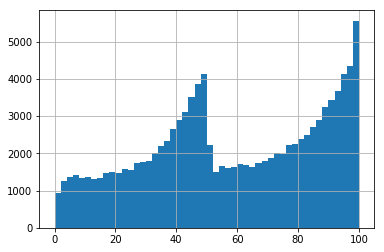

In [7]:
beerdf['rating'].hist(bins=50)

Interesting distribution. The ratings seem to mostly concentrate around 50 and 100.

Let's investigate which breweries and styles are the most popular.

------------------------------------------------------------------------
|Brewery                                                | Rating| Count|
------------------------------------------------------------------------
|Wicked Barrel                                          | 100.00|     1|
|Neill & Ross                                           | 100.00|     1|
|Westvleteren Abdij St. Sixtus                          |  99.50|     4|
|Brasserie Rochefort                                    |  99.33|     3|
|Schramm’s Mead                                         |  99.14|    22|
|Domaine des Côtes d’Ardoise                            |  99.00|     1|
|Takasago Shuzo Sake Co.                                |  99.00|     1|
|Entre Pierre et Terre                                  |  99.00|     1|
|Boombox                                                |  99.00|     1|
|Clos Saint-Denis                                       |  99.00|     2|
|Backacre Beermakers                               

(95, 102)

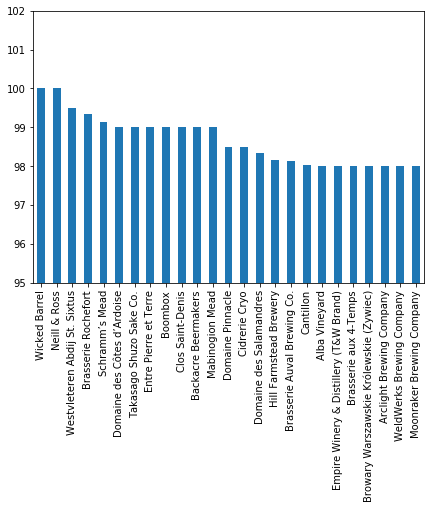

In [8]:
# Get the n most highly rated breweries
# ------------------------------------------------------------------------------
n = 25
byBrewery = beerdf.groupby(['brewery'])
brewerymeans = byBrewery.rating.mean().sort_values(ascending=False)
brewerycounts = [byBrewery.get_group(brewery)['beer'].count()
                 for brewery in brewerymeans.index]
brewerymeans.index = brewery_le.inverse_transform(brewerymeans.index)  # Decode

# Prints table of n most highly rated breweries with avg rating and beer count
print('-'*72)
print('|%-55s|%7s|%6s|' % ('Brewery', 'Rating', 'Count'))
print('-'*72)
for b, r, c in zip(brewerymeans[:n].index, brewerymeans[:n], brewerycounts[:n]):
    print('|%-55s|%7.2f|%6d|' % (b, r, c))
print('-'*72)

# Plot a Pareto chart of n most highly rated breweries
ax = brewerymeans.iloc[:n].plot.bar(figsize=(7,5))
ax.set_ylim(95, 102)

For completeness, let's also look at the least popular breweries.

------------------------------------------------------------------------
|Brewery                                                | Rating| Count|
------------------------------------------------------------------------
|F. Sergejeffin Olut-tehdas Osakeyhtiö                  |   1.00|     1|
|Brew Detroit                                           |   1.00|     1|
|King Lucky Food Industrial Corporation                 |   1.00|     1|
|Abuljadayel Beverages                                  |   1.00|     1|
|Suntory (China)                                        |   1.00|     1|
|Crown Beverages                                        |   1.00|     1|
|Samarqand 1-son Pivo Zavodi                            |   1.00|     2|
|Tokominum                                              |   1.00|     1|
|Vanuatu Brewing Limited                                |   1.00|     1|
|Tibet Tiandi Green Beverage Development Co.            |   1.00|     1|
|Arrow Beverage Factory                            

(0, 3)

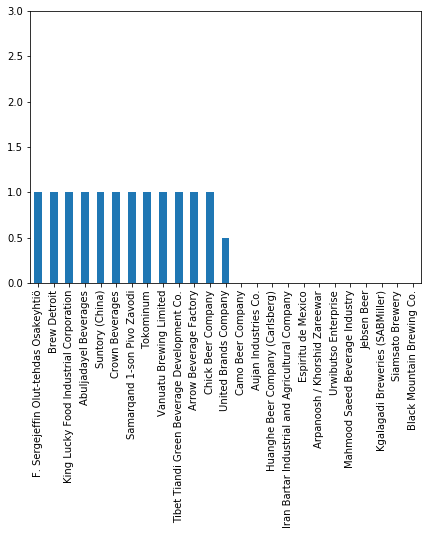

In [9]:
# Get the n most lowly rated breweries
# ------------------------------------------------------------------------------

# Prints table of n most lowly rated breweries with avg rating and beer count
print('-'*72)
print('|%-55s|%7s|%6s|' % ('Brewery', 'Rating', 'Count'))
print('-'*72)
for b, r, c in zip(brewerymeans[-n:].index, brewerymeans[-n:], brewerycounts[-n:]):
    print('|%-55s|%7.2f|%6d|' % (b, r, c))
print('-'*72)

# Plot a Pareto chart of n most highly rated breweries
ax = brewerymeans.iloc[-n:].plot.bar(figsize=(7,5))
ax.set_ylim(0, 3)

--------------------------------------------------
|Style                           | Rating|  Count|
--------------------------------------------------
|Ice Cider/Ice Perry             |  91.42|    133|
|Imperial Stout                  |  90.75|   4517|
|Imperial Porter                 |  88.63|    808|
|Saké - Koshu                    |  88.00|      4|
|Lambic Style - Gueuze           |  87.38|    132|
|Imperial IPA                    |  84.92|   3636|
|Sour/Wild Ale                   |  84.32|   3102|
|Lambic Style - Unblended        |  83.78|    104|
|Abt/Quadrupel                   |  83.76|    532|
|Barley Wine                     |  82.45|   2058|
|Sour Red/Brown                  |  81.97|    585|
|Black IPA                       |  81.45|   1472|
|American Strong Ale             |  80.57|   1418|
|Lambic Style - Fruit            |  78.58|    372|
|Baltic Porter                   |  78.47|    495|
|Foreign Stout                   |  76.69|    350|
|India Style Lager             

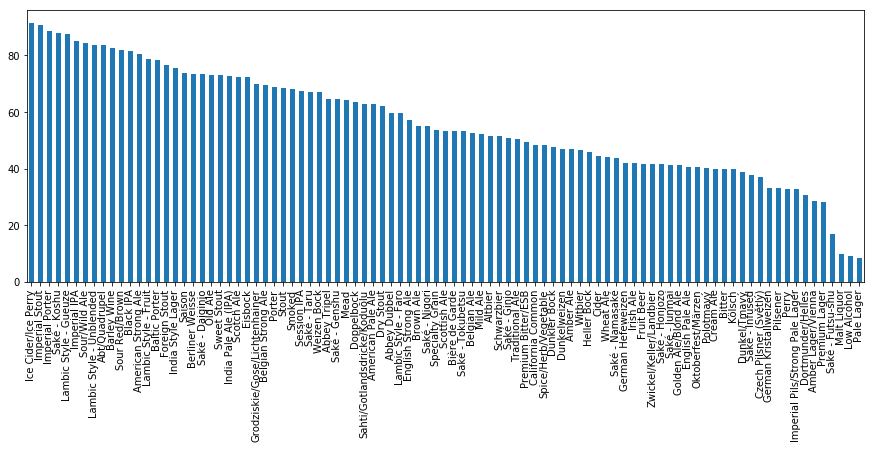

In [10]:
# Get the n most highly rated styles
# ------------------------------------------------------------------------------
n = 93  # All styles
byStyle = beerdf.groupby(by=['style'])
stylemeans = byStyle.rating.mean().sort_values(ascending=False)
stylecounts = [byStyle.get_group(style)['beer'].count()
                 for style in stylemeans[:n].index]
stylemeans.index = style_le.inverse_transform(stylemeans.index)  # Decode idx

# Prints table of n most highly rated breweries with avg rating and beer count
print('-'*50)
print('|%-32s|%7s|%7s|' % ('Style', 'Rating', 'Count'))
print('-'*50)
for s, r, c in zip(stylemeans[:n].index, stylemeans[:n], stylecounts):
    print('|%-32s|%7.2f|%7d|' % (s, r, c))
print('-'*50)

# Plot a Pareto chart of n most highly rated breweries
ax = stylemeans.iloc[:n].plot.bar(figsize=(15,5))
#ax.set_ylim(95, 102)

This concludes the initial analysis of the beer rating data. Let's see if we can build a model to predict beer ratings.

## Predicting Beer Ratings

### Baseline prediction

Let's get a baseline for the cost function. We will try to predict a beer's rating using averages for:

1. The total
2. The specific brewery
3. The specific style

Notice that we're using averages obtained from training set as prediction for training and test sets since it makes no since to predict test values using the values themselves.

In [11]:
# Baseline predictions
# ------------------------------------------------------------------------------

# Ground truth
y_train = beer_train['rating']
y_val = beer_valid['rating']
y_test = beer_test['rating']

# Update brewery average and style average in validation/test sets so that avgs 
# come only from the training set (doesn't make sense to predict what we know)
style_means = beer_train.groupby(by=['style']).rating.mean()
brewery_means = beer_train.groupby(by=['brewery']).rating.mean()
# Note if brewery/style has no mean we use total (trainig) avg=y.mean()
trainavg = y_train.mean()
for df in [beer_train, beer_valid, beer_train]:
    df['breweryavg'] = df['brewery'].map(lambda x: brewery_means[x]
                                         if x in brewery_means else trainavg)
    df['styleavg'] = df['style'].map(lambda x: style_means[x]
                                     if x in style_means else trainavg)

# Variables for looping over datasets
datasets = [beer_train, beer_valid, beer_test]
ysets = [y_train, y_val, y_test]
names = ['training', 'validation', 'test']
spaces = [9, 7, 13]  # For nice formatting of print statements

# Prediction based on total (training) avg
for y, name, space in zip(ysets, names, spaces):
    print('Cost applied to %s set (prediction based on total avg): %*.3f' %
          (name, space, cost(y, trainavg)))
print()

# Prediction based on style avg from train data
for df, y, name, space in zip(datasets, ysets, names, spaces):
    yhat = df['styleavg']
    print('Cost applied to %s set (prediction based on style avg): %*.3f' %
          (name, space, cost(y, yhat)))
print()

# Prediction based on brewery avg from train data
for df, y, name, space in zip(datasets, ysets, names, spaces):
    yhat = df['breweryavg']
    print('Cost applied to %s set (prediction based on brewery avg): %*.3f' %
          (name, space, cost(y, yhat)))

Cost applied to training set (prediction based on total avg):   820.885
Cost applied to validation set (prediction based on total avg): 821.347
Cost applied to test set (prediction based on total avg):       816.824

Cost applied to training set (prediction based on style avg):   408.390
Cost applied to validation set (prediction based on style avg): 408.674
Cost applied to test set (prediction based on style avg):       412.542

Cost applied to training set (prediction based on brewery avg):   270.963
Cost applied to validation set (prediction based on brewery avg): 369.629
Cost applied to test set (prediction based on brewery avg):       283.800


Looks like brewery average is the best predictor for a beers rating. This makes sense. Brewery fan loyalty is pretty big in craft beer. We will use the prediction using the brewery average as a baseline. This shouldn't be too hard to beat. First, let's get a better evaluation of this baseline.

In order to evaluate our model on the test data, we apply the cost function, find of predictions that are within 10 percentage points of the ground truth, show the descriptive statistics for the absolute errors, and we plot histograms for the errors (positive and negative) and for the absolute errors (absolute values applied to errors).

Cost applied to test (using Baseline prediction):  283.800

Percentage of absolute errors that are less than 10: 48.54%

Absolute Errors description:

count    22444.000000
mean        12.953263
std         10.771182
min          0.000000
25%          4.699569
50%         10.333333
75%         18.479155
max         84.755556
dtype: float64


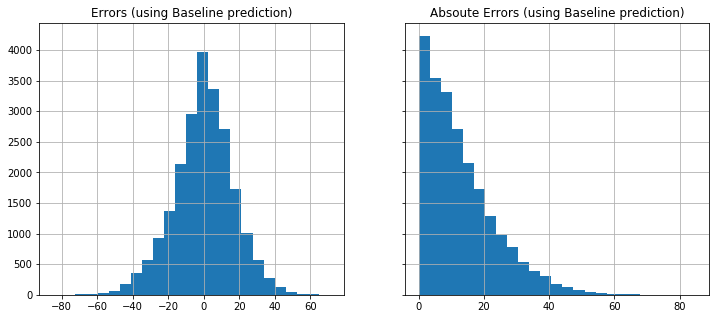

In [14]:
# Evaluation of baseline prediction using brewery avg
# ------------------------------------------------------------------------------
yhat = beer_test['breweryavg']
evaluate(y_test, yhat, 'Baseline prediction')

We will use the following as baseline metrics on which we will try to improve:

* test cost = 283.8, 
* percentage of predictions with 10 points of actual rating = 48.54%
* mean absolute error = 12.95, and
* standard deviation of absolute error = 10.77

Let's try to improve these using a simple prediction model: decision trees.

### Descision Tree Model

Let's see if we can do better with a simple decision tree model. First, we use the validation set to choose the hyper-parameters of the model and then we evaluate the model on the test set.

In [18]:
# Decision tree model
# ------------------------------------------------------------------------------

# Train the model
model = tree.DecisionTreeRegressor(max_depth=9, min_samples_split=90, 
                                   min_samples_leaf=3, min_impurity_split=1e-7)
X_train = beer_train.iloc[:, 1:-1]  # Cuts out: beer, rating
y_train = beer_train.iloc[:, -1]    # Cuts out: everything but rating
model.fit(X_train, y_train)

# Evaluate model on test and validation 
Xsets = [X_train, beer_valid.iloc[:, 1:-1]]
ysets = [y_train, beer_valid.iloc[:,-1]]
names = ['training', 'validation']
spaces = [9, 7]

for X, y, name, space in zip(Xsets, ysets, names, spaces):
    yhat = model.predict(X)
    print('Cost applied to %s set (using DecisionTreeRegressor): %*.3f' %
          (name, space, cost(y, yhat)))

Cost applied to training set (using DecisionTreeRegressor):   186.397
Cost applied to validation set (using DecisionTreeRegressor): 260.162


Training set and validation set saw an improvement in the cost. Let's see how the model evaluates on the test set.

Cost applied to test (using DecisionTreeRegressor):  205.072

Percentage of absolute errors that are less than 10: 58.00%

Absolute Errors description:

count    22444.000000
mean        10.762250
std          9.447217
min          0.000000
25%          3.584871
50%          8.118000
75%         15.484754
max         86.956466
Name: rating, dtype: float64


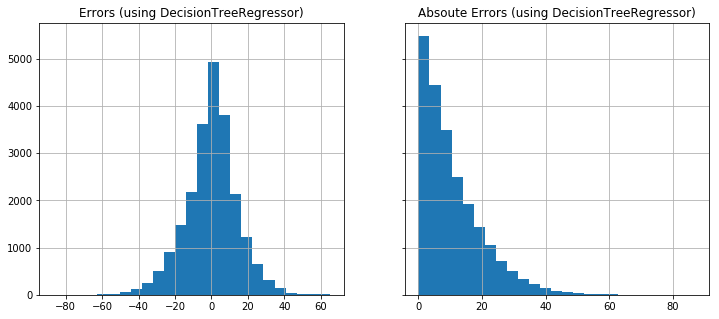

In [19]:
# Evaluate Decision Tree on test data
# ------------------------------------------------------------------------------
X_test = beer_test.iloc[:, 1:-1]
y_test = beer_test.iloc[:, -1]
yhat_test = model.predict(X_test)
evaluate(y_test, yhat_test, 'DecisionTreeRegressor')

Hey, that's a pretty good improvement! In particular,
* cost went down 78 points,
* percentage of predictions within 10 points went up 10%,
* mean absolute error decreased 2.2 points, and
* std dev of absolute error decreased 1.33 points.

Decision trees are pretty basic though. Surely we can do better with an ensemble method.

### Random Forest Model

Let's try to predict the beer ratings with a Random Forest model.

In [22]:
# Random Forest model
# ------------------------------------------------------------------------------
model = RandomForestRegressor(n_estimators=600, criterion='mse', 
                              max_features='sqrt', n_jobs=-1, max_depth=39, 
                              min_samples_split=22, min_samples_leaf=1, 
                              min_impurity_split=1e-8)
model.fit(X_train, y_train)
for X, y, name, space in zip(Xsets, ysets, names, spaces):
    yhat = model.predict(X)
    print('Cost applied to %s set (using RandomForestRegressor): %*.3f' %
          (name, space, cost(y, yhat)))

Cost applied to training set (using RandomForestRegressor):   128.258
Cost applied to validation set (using RandomForestRegressor): 239.557


Cost applied to test (using RandomForestRegressor):  187.683

Percentage of absolute errors that are less than 10: 58.96%

Absolute Errors description:

count    22444.000000
mean        10.362780
std          8.961013
min          0.000320
25%          3.610699
50%          8.003919
75%         14.754584
max         84.492177
Name: rating, dtype: float64


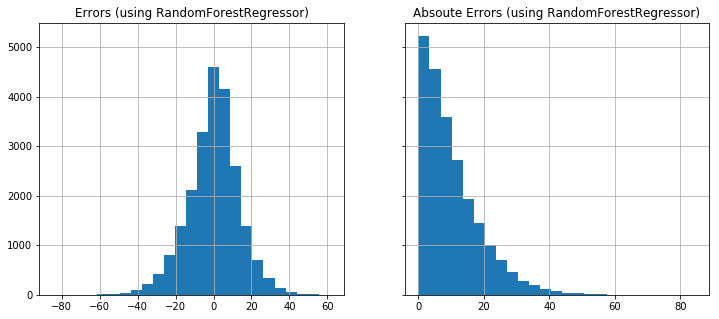

In [23]:
# Evaluate Random Forest on test data
# ------------------------------------------------------------------------------
yhat_test = model.predict(X_test)
evaluate(y_test, yhat_test, 'RandomForestRegressor')

Even better!

Let's investigate which features are even important to our model.

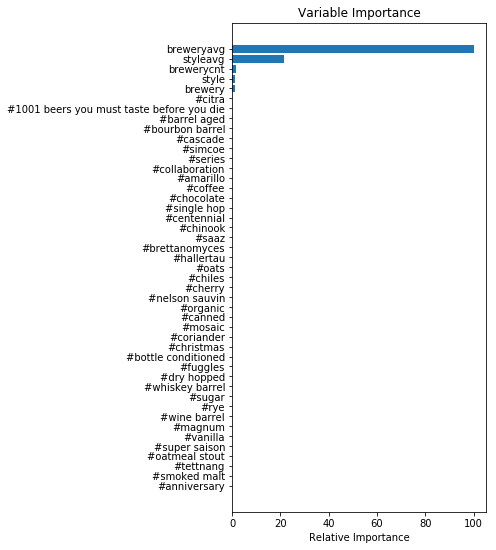

In [37]:
# Evaluating the importance of each feature
# ------------------------------------------------------------------------------
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,9))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The most important feature seems to be the average rating for the brewery that brewed the beer. Again, that makes sense because of brewery fan loyalty and... well.. a beer is only as good as the people who made it! Let's try another ensemble method to see if we can do any better.

### Gradient Boosting Model

Here we will try to use a Gradient Boosting model to predict beer ratings.

In [39]:
# Gradient Boosting model
# ------------------------------------------------------------------------------

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.2, 
                                  max_depth=7, min_samples_split=2)
model.fit(X_train, y_train)
for X, y, name, space in zip(Xsets, ysets, names, spaces):
    yhat = model.predict(X)
    print('Cost applied to %s set (using RandomForestRegressor): %*.3f' %
          (name, space, cost(y, yhat)))

Cost applied to training set (using RandomForestRegressor):   150.966
Cost applied to validation set (using RandomForestRegressor): 246.776


Cost applied to test (using GradientBoostingRegressor):  190.262

Percentage of absolute errors that are less than 10: 59.72%

Absolute Errors description:

count    22444.000000
mean        10.324223
std          9.147457
min          0.000643
25%          3.371655
50%          7.818010
75%         14.802792
max         83.820274
Name: rating, dtype: float64


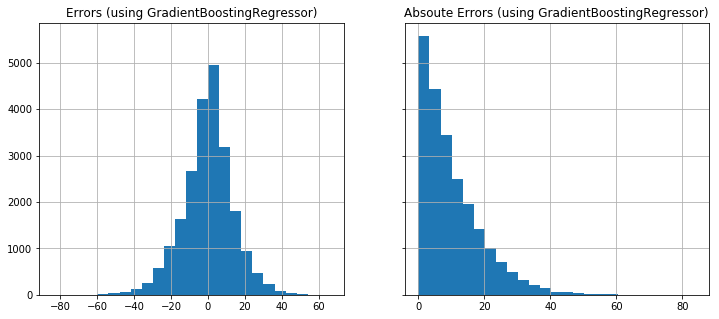

In [40]:
# Evaluate Gradient Boosting on test data
# ------------------------------------------------------------------------------
yhat_test = model.predict(X_test)
evaluate(y_test, yhat_test, 'GradientBoostingRegressor')

It looks like the percentage predicted within 10 points went down, as did the mean of the absolute error. However, the variance and overall cost of the test set went up. Let's see what the most important features are for this model.

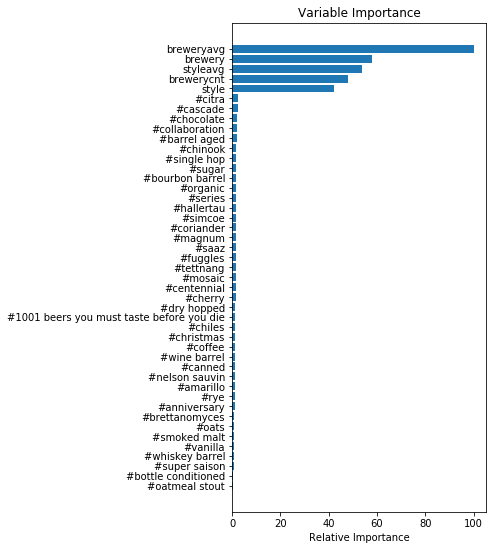

In [43]:
# Evaluating the importance of each feature
# ------------------------------------------------------------------------------
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,9))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Breweryavg is again the most important feature, but some of the other features also have pretty high relative importance.

## Conclusion

I'm surprised that we can predict nearly 60% of beers within 10 points based on relatively little information about the beer. It would have been nice to also know how many people rated the beer. I imagine this would have an effect on the overall rating. It might also be interesting to apply a neural network model to the problem and see how it compares to the ensemble methods used.